In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

input_data = pd.read_excel(r'/Users/dylan/DataBase/top7-sharpe_ratio_rank-30.xlsx')
signal_result = pd.read_excel(r'/Users/dylan/DataBase/signal_process/benchmark_result-30_5.xlsx')


In [3]:
input_model = input_data['model_selected'].shift(-1).dropna()
input_model_df = pd.DataFrame()
for i in range(len(input_model)): 
    # 将字符串转换为字典,并转化为dataframe
    new_df = pd.DataFrame.from_dict(eval(input_model.iloc[i]),orient = 'index',columns = ['signal'])
    input_model_df = input_model_df.append(new_df)
input_model_df = input_model_df.reset_index().rename(columns = {'index' : 'model'})
input_model_df


,model,signal
0,2日开盘价持续下跌-1121-bagc,0.15
1,2日开盘价持续下跌-1220-xgb,0.15
2,2日开盘价持续下跌-1220-rfc,0.15
3,2日开盘价持续下跌-1220-dtc,0.15
4,2日开盘价持续下跌-1121-xgb,0.13
...,...,...
163,2日开盘价持续下跌-1230-knnc,0.14
164,2日开盘价持续下跌-1220-bagc,0.17
165,2日开盘价持续下跌-1132-bagc,0.15
166,2日开盘价持续下跌-1131-bagc,0.17


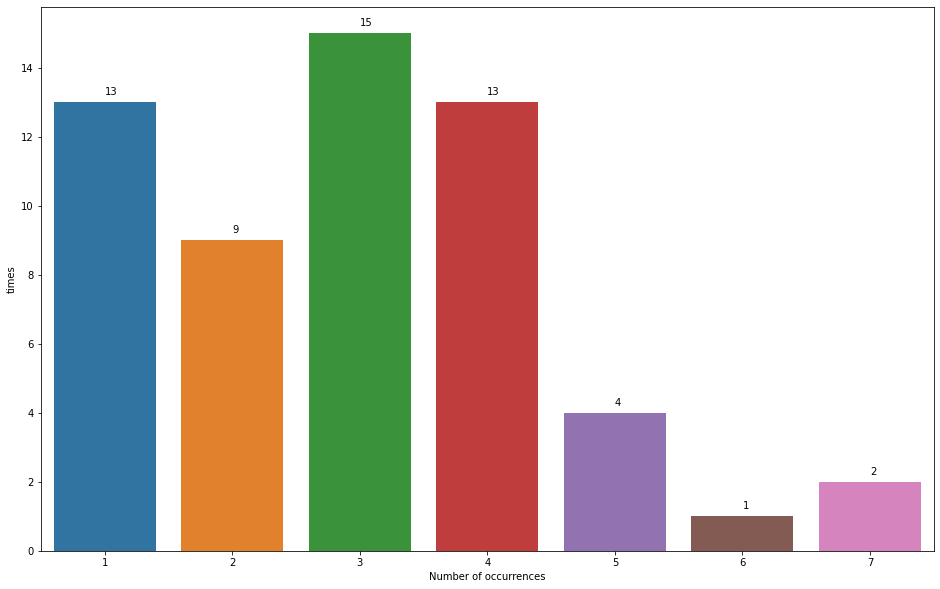

In [12]:
# 频次统计
df = input_model_df.loc[:,'model'].value_counts().to_frame()
df.reset_index(level=0, inplace=True)
fig = plt.gcf()
fig.set_size_inches( 16, 10)

image = sns.barplot(data = df.groupby(by = 'model').agg('count'), x = [1,2,3,4,5,6,7],y = 'index' )
image.set_xlabel('Number of occurrences')
image.set_ylabel('times')

for x,y in zip([1,2,3,4,5,6,7],list(df.groupby(by = 'model').agg('count')['index'])):
    image.text(x-1,y+0.2,y) # 坐标轴的位置进行了重新排序
œ



In [205]:
# 涉及模型
input_model_df.drop_duplicates('model').count()


model     57
signal    57
dtype: int64

In [206]:
# 涉及模型的数量
input_model_df.drop_duplicates('model').count()

model     57
signal    57
dtype: int64

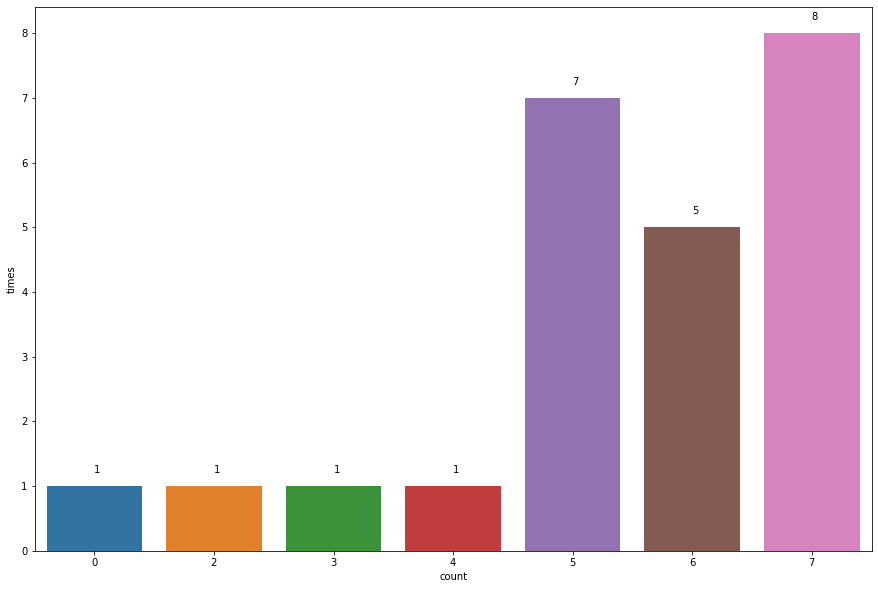

In [31]:
# 每期替换
list1 = list(input_data['start_date'])
del list1[-1]
list2 = range(int(len(input_model_df)/7))
#input_data.insert(input_data.shape[1],'count',0)
for i,x in zip(list2, list1): 
    if i*7 == len(input_model_df) - 7:
        break
    i = 7*i
    filter = input_model_df.iloc[i:i+7].append(input_model_df.iloc[i+7:i+14])
    filter = filter.drop_duplicates('model')
    count = 7 - (14 - filter.count())
    input_data.loc[input_data['start_date'] == x,'count'] = int(count.iloc[0])
input_data['count'] = input_data['count'].shift(1)
plt.figure(figsize=(15, 10))
image = sns.barplot(data = input_data.groupby(by = 'count').agg('count'),x = [0,2,3,4,5,6,7],y = 'start_date')

image.set_ylabel('times')
image.set_xlabel('count')
input_data.groupby(by = 'count').agg('count')


for x,y in zip(list(range(7)),list(input_data.groupby(by = 'count').agg('count')['start_date'])):
    image.text(x,y+0.2,y) # 坐标轴的位置进行了重新排序




In [216]:
# 在验证期超过benchmark的比例
list1 = list(range(int(len(input_model_df)/7)))
list2 = list(input_data['end_date'])
# del list2[0]
model_df = pd.DataFrame()
for i,x in zip(list1,list2) :
        i = 7*i
        filter = input_model_df.iloc[i:i+7]    
        for model in filter['model']: 
                # modelmark可能为空
                model_mark = signal_result[(signal_result['end_date'] == x) & (signal_result['model'] == model)]
                #print(model_mark)
                # benchmark可能为空
                benchmark = signal_result[(signal_result['end_date'] == x) & (signal_result['model'] == 'benchmark')]
                #print(benchmark)
                if model_mark.empty or benchmark.empty :
                        break
                if model_mark['sharpe_ratio_sp'].iloc[0] >= benchmark['sharpe_ratio_sp'].iloc[0] :
                        model_mark['larger_now'] = 1
                else: 
                        model_mark['larger_now'] = 0
                model_df = model_df.append(model_mark)
        model_df = model_df.append(benchmark)
# 观测数据
model_df.count()
model_df[model_df['larger_now'] == 1].count()
#model_df[model_df['larger_now'] == 0].count()
model_df.head(50)

def get_large_ratio(x): 
        ratio = x[x == 1].count() / 7 
        return ratio
# 超过比例
model_df['ratio_now'] = model_df.groupby('start_date')['larger_now'].transform(get_large_ratio)
model_df.to_excel(r'/Users/dylan/DataBase/Top-7-model-ratio-now.xlsx')

<ipython-input-216-071436fd23d7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_mark['larger_now'] = 1
<ipython-input-216-071436fd23d7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_mark['larger_now'] = 0


In [228]:

# 在验证期超过benchmark的比例
list1 = list(range(int(len(input_model_df)/7)))
list2 = list(input_data['end_date'])
del list2[0]
print(list2)
model_df = pd.DataFrame()
for i,x in zip(list1,list2) :
        i = 7*i
        filter = input_model_df.iloc[i:i+7]    
        for model in filter['model']: 
                # modelmark可能为空
                model_mark = signal_result[(signal_result['end_date'] == x) & (signal_result['model'] == model)]
                #print(model_mark)
                # benchmark可能为空
                benchmark = signal_result[(signal_result['end_date'] == x) & (signal_result['model'] == 'benchmark')]
                #print(benchmark)
                if model_mark.empty or benchmark.empty :
                        break
                if model_mark['sharpe_ratio_sp'].iloc[0] >= benchmark['sharpe_ratio_sp'].iloc[0] :
                        model_mark['larger_next'] = 1
                else: 
                        model_mark['larger_next'] = 0
                model_df = model_df.append(model_mark)
        model_df = model_df.append(benchmark)
model_df.count()
def get_large_ratio(x): 
        ratio = x[x == 1].count() / 7 
        return ratio
model_df['ratio_next'] = model_df.groupby('start_date')['larger_next'].transform(get_large_ratio)
model_df.to_excel(r'/Users/dylan/DataBase/Top-7-model-ratio-next.xlsx')




['2018-07-25', '2018-09-05', '2018-10-25', '2018-12-06', '2019-01-21', '2019-03-11', '2019-04-23', '2019-06-10', '2019-07-22', '2019-09-02', '2019-10-22', '2019-12-03', '2020-01-15', '2020-03-05', '2020-04-17', '2020-06-03', '2020-07-17', '2020-08-28', '2020-10-19', '2020-11-30', '2021-01-12', '2021-03-02', '2021-04-14', '2021-05-31']


<ipython-input-228-a7ab115a878c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_mark['larger_next'] = 1
<ipython-input-228-a7ab115a878c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_mark['larger_next'] = 0
